# Introduction
This case study began as my final project for my Data / Statistical Analysis class in college. The goal of the study was to compare the three most popular strategies used by gamblers when playing blackjack, to find what was the statistically best strategy to utilize. This case study eventually evolved into a larger project that included a full desktop version of Blackjack that includes a fully functioning UI and an option to recieve hints based on the top strategy.

I preformed this anaylsis by first coding a very basic representation of Blackjack into Python. I would then us Jupyter Notebooks in order to test each strategy.

# Initial Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import gaussian_kde

# Creating Basic Blackjack Representation

The game of blackjack that you find in many casinos is often suprisingly complex and can differ widely. Because of these differences I have stripped away a lot of the complexitiy of the game which may change depending on the region of play. Most of this complexitiy deals with the winnings and payouts however so the simplification will not affect our anaylsis of winning percentages. However, past the simplification of betting there are a few key aspects of the game that vary and have an effect on the outcome and probability of a game. As such I chose the most popular methods and describe the rules as following.



*   These games are based on 1-on-1 tables where there is only one player per dealer
*   The object of the game is to have a higher hand then the dealer, without going over 21
*   All face cards are worth 10, as such the program prints them as additional 10 cards
*   Aces are worth either 11 or 1, which ever gives you the highest score without going over 21
*   Like face cards Aces are printed by their number value, either 11 or 1
*   You the player start with 2 cards from the deck
*   The dealer starts the game with 1 visible card
*   If you go over 21, called busting, you lose no matter the dealers hand
*   The dealer will draw a new card, called hitting, until their hand is equal to 17 or higher
*   If the dealer busts you win no matter your hand, unless you have already bust
*   During your turn you have 2 possible moves
  *  Hit - draw another card from the deck
  *  Stay - end your turn. Once you stay only the dealer can draw more cards
*   You draw all the cards you want, one at a time, prior to the dealer drawing their cards
*   If you and the dealer have equal hands the game is a tie, called a Push

Below is a python representation of this simplified version of blackjack that allows you to simulate a game with inputs from the user.





In [2]:
#This helper function takes a 'card' from the deck and places it in a hand.
def drawcard(hand, deck):
    carddraw = np.random.choice(deck)
    hand.append(carddraw)
    deck.remove(carddraw)
    return hand, deck

def blackjack_game():
    #This list of 52 numbers represent a deck of cards
    deck = [2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,11]
    playerhand = [] #list representing all the 'cards' a player has
    dealerhand = [] #List representing all the 'cards' a dealer has
    playerhand, deck = drawcard(playerhand, deck) #Drawcard function called twice at the beginning of the game
    playerhand, deck = drawcard(playerhand, deck)
    dealerhand, deck = drawcard(dealerhand, deck)#Drawcard function called at beginning of the game representing the visible dealer card
    action = 'i' #Variable to represent user input, initialized to 'i'
    while action != 's': #While the player hasnt input 's' for stay
        #If the player has bust but has an Ace switch its score to a 1 from an 11 as per standard Blackjack rules
        if sum(playerhand) > 21 and 11 in playerhand:
            playerhand.remove(11)
            playerhand.append(1)
        #Allow the player to choose to hit or stay if they have not busted or gotten 21
        if sum(playerhand) < 21:
            print("Dealer's Card: ", dealerhand[0], "\n Your current hand: ", playerhand, ' summing to a toal of: ', sum(playerhand))
            action = input('Your Move(s - Stay, h - Hit): ')
            #If player calls for a hit call the drawcard function to add another card to the hand
            if action == 'h':
                playerhand, deck = drawcard(playerhand, deck)
        #If the player reaches a score of 21 skip to dealer turn
        elif sum(playerhand) == 21:
            action = 's'
        #If the player has a score higher then 21 call lose for bust
        else:
            print('\n You Lost! \n Your hand was: ', playerhand,' summing to a total of: ',sum(playerhand),'\n The dealers hand was: ', dealerhand,' summing to a total of: ',sum(dealerhand))
            return
    #Per standard Blackjack rules the dealer will continue to hit until they have a score equal to or over 17
    while sum(dealerhand) < 17:
        dealerhand, deck = drawcard(dealerhand, deck) #Adds new card to dealers hand
        #If the dealer busted but has an Ace change the Ace value to 1 per standard Blackjack rules
        if sum(dealerhand) > 21 and 11 in dealerhand:
            dealerhand.remove(11)
            dealerhand.append(1) 
    #If dealer has busted or player has a higher score then dealer the player wins
    if sum(dealerhand) > 21 or sum(dealerhand) < sum(playerhand):
        print('\n You Won! \n Your hand was: ', playerhand,' summing to a total of: ',sum(playerhand),'\n The dealers hand was: ', dealerhand,' summing to a total of: ',sum(dealerhand))
        return
    #If the dealer has a higher score then the player the dealer wins
    elif sum(dealerhand) > sum(playerhand):
        print('\n You Lost! \n Your hand was: ', playerhand,' summing to a total of: ',sum(playerhand),'\n The dealers hand was: ', dealerhand,' summing to a total of: ',sum(dealerhand))
        return
    #If the dealer and player have the same score the game is a push, or tie
    else:
        print('\n You Tied! \n Your hand was: ', playerhand,' summing to a total of: ',sum(playerhand),'\n The dealers hand was: ', dealerhand,' summing to a total of: ',sum(dealerhand))
        return

### Play a game of Blackjack:

In [3]:
blackjack_game()

Dealer's Card:  4 
 Your current hand:  [3, 7]  summing to a toal of:  10
Your Move(s - Stay, h - Hit): h
Dealer's Card:  4 
 Your current hand:  [3, 7, 10]  summing to a toal of:  20
Your Move(s - Stay, h - Hit): s

 You Won! 
 Your hand was:  [3, 7, 10]  summing to a total of:  20 
 The dealers hand was:  [4, 10, 10]  summing to a total of:  24


# Strategies

There are numerous different strategies players of blackjack deploy in order to better their odds in winning. The goal of this project is to take several of the most popular strategies and run simulations on them using our simplified version of blackjack to determine what your probability of winning at a blackjack table really is and which stratgies give you the best chances of winning.

For each strategy we test we will modify the blackjack_game function used above to implement the strategy, We will then use the built-in numpy functions to run simulations on the strategy, saving the results and analysising the successfulness of each strategy.


## Strategy 1 - Dealer's 17

The first strategy we will look at is the same strategy the dealers use. If your hand is below 17 you hit but if your hand is equal to or greater then 17 you stay. This strategy is based on the fact that hitting on a number higher then 16 gives you a fairly large probability to bust, and as such you are better to stay and hope that the opponent, in this case the dealer, either busts or stops prior to reaching your score. This is considered one of the most basic and simple strategies but still has its merits and supporters often cite the fact that the dealers using the strategy represents its effectiveness.

In order to implement this strategy we take our basic function and replace our current player input based system with an identical system that the dealer uses.

In [4]:
def dealer_17():
    deck = [2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,11]
    playerhand = []
    dealerhand = []
    playerhand, deck = drawcard(playerhand, deck)
    playerhand, deck = drawcard(playerhand, deck)
    dealerhand, deck = drawcard(dealerhand, deck)
    while sum(playerhand) < 17:
        playerhand, deck = drawcard(playerhand, deck)
        if sum(playerhand) > 21 and 11 in playerhand:
            playerhand.remove(11)
            playerhand.append(1)
    if sum(playerhand) > 21:
        return 'L', playerhand, dealerhand
    if sum(playerhand) == 21:
        return 'W', playerhand, dealerhand
    while sum(dealerhand) < 17:
        dealerhand, deck = drawcard(dealerhand, deck)
        if sum(dealerhand) > 21 and 11 in dealerhand:
            dealerhand.remove(11)
            dealerhand.append(1)
    if sum(dealerhand) > 21 or sum(dealerhand) < sum(playerhand):
        return 'W', playerhand, dealerhand
    elif sum(dealerhand) > sum(playerhand):
        return 'L', playerhand, dealerhand
    else:
        return 'T', playerhand, dealerhand

## Strategy 2 - No Bust

The second strategy we will look at is more conservative. In theory behind the strategy revolves around one of the basic dealer advantages of blackjack, which is that the dealer goes last giving you a chance to bust before the dealer. If you and the dealer both bust in the same game of blackjack, since you had busted first you still lose the round. This strategy simply takes a conservative approach, staying when there is any chance at bust. This often leads you to stay at very low totals in the hopes the dealer will bust.

In order to implement this strategy we take our dealer_17 function from strategy 1 and adjust the limit from 17 to 11. As any total over 11 has some risk of busting in it.

In [5]:
def no_bust():
    deck = [2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,11]
    playerhand = []
    dealerhand = []
    playerhand, deck = drawcard(playerhand, deck)
    playerhand, deck = drawcard(playerhand, deck)
    dealerhand, deck = drawcard(dealerhand, deck)
    while sum(playerhand) < 11:
        playerhand, deck = drawcard(playerhand, deck)
        if sum(playerhand) > 21 and 11 in playerhand:
            playerhand.remove(11)
            playerhand.append(1)
    if sum(playerhand) > 21:
        return 'L', playerhand, dealerhand
    if sum(playerhand) == 21:
        return 'W', playerhand, dealerhand
    while sum(dealerhand) < 17:
        dealerhand, deck = drawcard(dealerhand, deck)
        if sum(dealerhand) > 21 and 11 in dealerhand:
            dealerhand.remove(11)
            dealerhand.append(1)
    if sum(dealerhand) > 21 or sum(dealerhand) < sum(playerhand):
        return 'W', playerhand, dealerhand
    elif sum(dealerhand) > sum(playerhand):
        return 'L', playerhand, dealerhand
    else:
        return 'T', playerhand, dealerhand

## Strategy 3 - Chart Strategy

The third strategy we will look at is called "basic strategy" or "chart strategy" though it is far from basic, it is by far the most complex strategy that can be implemented in 1-on-1 games of blackjack without using card counting. It has a specific action to take based on what your total cards compared to what the dealer is showing. It is represented by the following chart: (Only part of the chart is included as the rest deals with aspects of the game removed for these simulations)

<img src="../../../img/blackjack-chart.png" width="400"/>

*Note D and Ds stand for double which doubles the player's bet, since this has been removed for these simulations a D means hit and a Ds means stay*

This chart is praised at the best strategy however it is complex and require you to memorize the chart, does this extra complexity and time spent memorization pay off compared to the first two strategies, does this tilt the odds of winning in your favor?

In order to implement this strategy we use our basic outline however we have to build a relatively complex branching system for the player's decisions that uses a action variable similar to the one used in the user input game.

In [6]:
def chart_strat():
    deck = [2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,11]
    playerhand = []
    dealerhand = []
    playerhand, deck = drawcard(playerhand, deck)
    playerhand, deck = drawcard(playerhand, deck)
    dealerhand, deck = drawcard(dealerhand, deck)
    
    
    action = 'i'
    while action != 's':
        if 11 in playerhand: #If there is an Ace in the player's hand follow the soft totals
            if sum(playerhand) < 18: #All hands over 17 the player stays on
                if sum(playerhand) == 17: #If the playerhand = 17 hitting or staying depends on dealers card
                    if dealerhand[0] < 9: #If dealers card is less then 9 you stay
                        action = 's'
                    else: #If dealers card is greater then 9 you hit
                        playerhand, deck = drawcard(playerhand, deck)
                else: #If player's hand is less then 17 hit
                    playerhand, deck = drawcard(playerhand, deck)
            elif sum(playerhand) > 21: #If player has busted return loss
                return 'L', playerhand, dealerhand
            else: #If player hasnt busted but is over 17 stay
                action = 's'
        #If there isn't a high score Ace use hard totals
        if sum(playerhand) >= 17: #If playerhand is equal or greater then 17 stay
            action = 's'
        elif sum(playerhand) < 12: #If playerhand is less then 12 hit
            playerhand, deck = drawcard(playerhand, deck)
        elif sum(playerhand) == 12:
            if sum(dealerhand) in range(4,7): #If player hand is 12 and dealers hand is 4, 5, 6 stay
                action = 's'
            else: #If player hand is 12 and dealers hand is not 4, 5, 6 hit
                playerhand, deck = drawcard(playerhand, deck)
        else: #If player hand is 13, 14, 15, 16 and dealers hand is less then 7 stay. If dealers hand is 7 or greater hit
            if dealerhand[0] < 7:
                action = 's'
            else:
                playerhand, deck = drawcard(playerhand, deck)
        if sum(playerhand) > 21:#If player has busted return loss
            return 'L', playerhand, dealerhand
        if sum(playerhand) == 21:
            return 'W', playerhand, dealerhand
    if sum(playerhand) > 21:#If player has busted return loss
        return 'L', playerhand, dealerhand
    if sum(playerhand) == 21:
        return 'W', playerhand, dealerhand
    
    while sum(dealerhand) < 17:
        dealerhand, deck = drawcard(dealerhand, deck)
        if sum(dealerhand) > 21 and 11 in dealerhand:
            dealerhand.remove(11)
            dealerhand.append(1)
    if sum(dealerhand) > 21 or sum(dealerhand) < sum(playerhand):
        return 'W', playerhand, dealerhand
    elif sum(dealerhand) > sum(playerhand):
        return 'L', playerhand, dealerhand
    else:
        return 'T', playerhand, dealerhand

# Simulation & Results

Now we will run 100,000 games of blackjack with each strategy, summing up the win loss ratio of each. Below is the code for our simulator function that runs the given algorithm 100,000 times before outputing win percentages, average hand and a graph based on win / loss and hands.

In [7]:
def graphdensity(phandtot, dhandtot, function):
    xy = np.vstack([phandtot,dhandtot])
    z = gaussian_kde(xy)(xy)
    stri2 = "Density"
    plt.suptitle(stri2)
    plt.axis('equal')
    plt.scatter(phandtot, dhandtot, c=z, s=100, edgecolor='')
    plt.ylabel('Dealer Hand Score')
    plt.xlabel('Player Hand Score')
    plt.show()

def simulator(function):
    i = 0
    results = []
    win = 0
    loss = 0
    ties = 0
    avg_phand = 0
    avg_phand_w = 0
    avg_phand_l = 0
    avg_phand_t = 0
    avg_dhand = 0
    avg_dhand_w = 0
    avg_dhand_l = 0
    avg_dhand_t = 0
    phandtot = []
    dhandtot = []
    while i < 100000:
        temp, phand, dhand = function()
        results.append(temp)
        phandtot.append(sum(phand))
        dhandtot.append(sum(dhand))
        avg_phand += sum(phand)
        avg_dhand += sum(dhand)
        if temp == 'W':
            win += 1
            avg_phand_w += sum(phand)
            avg_dhand_w += sum(dhand)
        elif temp == 'L':
            loss += 1
            avg_phand_l += sum(phand)
            avg_dhand_l += sum(dhand)
        else:
            ties += 1
            avg_phand_t += sum(phand)
            avg_dhand_t += sum(dhand)
        i += 1
    total = len(results)
    avg_phand = avg_phand / total
    avg_phand_w = avg_phand_w / win
    avg_phand_l = avg_phand_l / loss
    avg_phand_t = avg_phand_t / ties
    avg_dhand = avg_dhand / total
    avg_dhand_w = avg_dhand_w / win
    avg_dhand_l = avg_dhand_l / loss
    avg_dhand_t = avg_dhand_t / ties
    avg_phand_t = (avg_phand_t + avg_dhand_t) / 2
    print('Win percentage: ', (win / total) * 100, ' with an average hand of ',  avg_phand_w, ' versus an average dealer hand of ', avg_dhand_w)
    print('Loss percentage: ', (loss / total) * 100, ' with an average hand of ',  avg_phand_l, ' versus an average dealer hand of ', avg_dhand_l)
    print('Tie percentage: ', (ties / total) * 100, ' with an average hand of ', avg_phand_t)
    phand_w = []
    phand_l = []
    phand_t = []
    dhand_w = []
    dhand_l = []
    dhand_t = []
    i = 0
    while i < len(phandtot):
        if phandtot[i] == dhandtot[i]:
            phand_t.append(phandtot[i])
            dhand_t.append(dhandtot[i])
        elif phandtot[i] < dhandtot[i]:
            phand_l.append(phandtot[i])
            dhand_l.append(dhandtot[i])
        else:
            phand_w.append(phandtot[i])
            dhand_w.append(dhandtot[i])
        i += 1
    plt.scatter(phand_l, dhand_l, color='green', label='Win')
    plt.scatter(phand_w, dhand_w, color='red', label='Loss')
    plt.scatter(phand_t, dhand_t, color='gray', label='Tie')
    plt.axis('equal')
    plt.ylabel('Dealer Hand Score')
    plt.xlabel('Player Hand Score')
    stri = "Possible Outcomes"
    plt.suptitle(stri)
    plt.legend()
    plt.show()
    graphdensity(phandtot, dhandtot, function)

## Simulating Dealer's 17

Win percentage:  42.169000000000004  with an average hand of  19.54751120491356  versus an average dealer hand of  17.0231212502075
Loss percentage:  49.102000000000004  with an average hand of  21.319437090138894  versus an average dealer hand of  12.568591910716467
Tie percentage:  8.729000000000001  with an average hand of  18.6592965975484


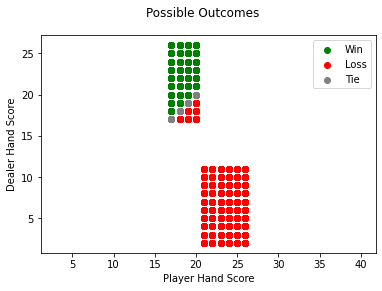

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  import sys


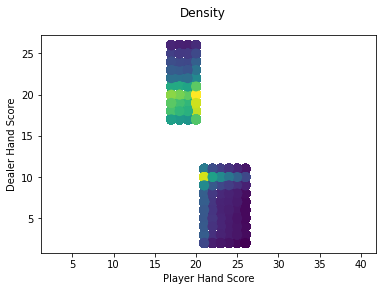

In [8]:
simulator(dealer_17)

The graph for this strategy is seperated in to two main groups of data, this will be true for our other two strategies as well. The bottom right grouping is a 100% loss rate because this grouping represents the case when a player busts. The reason for this distinct groupings is because the dealer will use the dealer17 strategy, meaning the only time a score will be below 17 on the Y axis is when a player busts. In the second grouping there is a section of data at the vary top above the 20 on the Y axis that represents a dealers's bust. We then have a line of data ranging from 17 to 20 on both axis that represents the tie line. With the smallest tie coming when both hands are equal to 17 and the largest tie coming when both hands are equal to 20. There is small areas area above and to the left of the tie line that represents a player win but not a dealers bust. Similarily below and to the right of the tie line represents a player loss but not a players bust.

In the chart we can see the range where the player didn't bust to be 4 datapoint wide, which is to be expected as it represents a dealers handscore of 17, 18, 19 & 20 as the player will always hit on something lower then a 17 and anything higher is a garenteed win or a bust. On average to tie players will have a hand of about 18-19 which makes since with this strategy because for no one to bust and for both players not to hit both of the hands must be in the 17-21 range. In addtion with this strategy you have a win percentage of about 42% which is not ideal as you win less then half the time, however your loss rate (due to the 8% tie rate) is also slightly under 50% at 49%, meaning you are losing about half your hands. Another interesting statistic that comes out of the data is on loss the players average hand is over 21, meaning that the majority of the losses come from the player busting rather then the player's score being beaten. This is seen with the density graph showing a warmer color in the top left of the bottom grouping of data showing that it is common to bust. The majority of the outcomes are still in thee scoring range in which niether player busts. The most common outcome was actually a 20-20 tie.

## Simulating No Bust

Win percentage:  40.419  with an average hand of  17.138177589747396  versus an average dealer hand of  20.240035626809174
Loss percentage:  54.049  with an average hand of  14.745730725822865  versus an average dealer hand of  19.13017817165905
Tie percentage:  5.532  with an average hand of  18.727946493130876


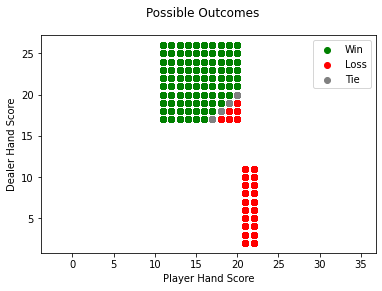

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  import sys


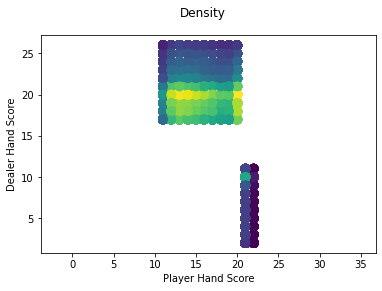

In [9]:
simulator(no_bust)

Much of what was covered for the first graph hold true to the second graph, however there are some key difference. With the more conservative strategy the bottom right grouping of data have shrunk in it's spread, in theory it should only be one dataset wide representing when the dealer gets a 21, however it is shown as 2 datapoint wide. The top left grouping has a much larger spread as the player will no longer hit on a score of 12, 13, 14, 15, or 16. Although this strategy eliminates busting, as is seen by the almost 7 points lower average hand score on loss, it does not improve your odds of winning. In fact this strategy proves very inefficent. With a win precentage of about 40% and a loss percentage of over 54% this would not be a wise strategy to employ. A interesting fact remains that dispite the different strategy the average score for tying remains almost unchanged, if you think about it from a probabilities stand point however this makes sense as the range for tying remains unchanged from 17-20 even though the range of player hand scores have changed. However, what has changed fairly dramatically is the chance for a tie, which makes sense because of the larger acceptable range of player score, however as we will see in our next strategy (which has a similar sized spread) this is not the full explination behind such a low chance to tie. This is due to the fact that there was no increase in the range of dealer hand scores. As shown in the density graph this method eliminates busting by the player and while maintaining the most likely outcome to still be a scoring finish. The most common outome was still a 20-20 tie joined by a 20-13 Dealer win.

## Simulating Chart Strategy

Win percentage:  42.416  with an average hand of  18.67573557148246  versus an average dealer hand of  18.252758393059224
Loss percentage:  50.112  with an average hand of  19.880707215836527  versus an average dealer hand of  14.72782966155811
Tie percentage:  7.4719999999999995  with an average hand of  18.73059421841542


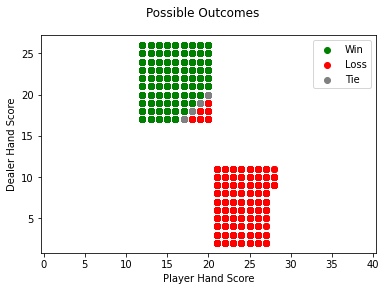

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  import sys


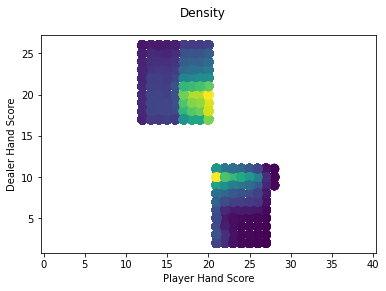

In [10]:
simulator(chart_strat)

Finally within the chart strategy we see a relatively even distrabution of point between groupings 1 and 2, both of which have a large range. Similar to the first Dealer 17 strategy we have a win percentage over 42% and a loss percentage of about 50%. However based on the loss average player hand it appears that you are far less likely to loss from busting then you were in the Dealer 17 strategy. In addition, furthering our insight from strategy 2, the average tie hand remains almost unchanged. Just as before the most likely player bust scinario is when the dealer has a score of 10, from this we can gather that the most common starting card for the dealer is 10, which if you examine the score weights in a deck of cards makes sense. In addition just like before the most common outcome is a 20-20 tie. Examining the density chart you will see the chart strategy and the Dealer 17 strategy have very similar density distrubtions, but with the chart strategy having a larger range of player scores. Looking closely to the actual chart strategy you can see that for the most part the chart follows a similar hit if below 17 guide as the Dealer 17 strategy.

# Conclusion

In conclusion we see that even using one of the 3 most popular strategies the odds are still not in your favor when you sit down at the blackjack table, although they are not entirely stacked against you. I would imagine if you run similar tests on the other forms of gambling you would find that although the odds are not in your favor they are better then most other forms of gambling. As for the strategies themselves we see that by a fairly significant margin the No Bust strategy is the worst with its win rate of about 40%. In researching strategies I found that many players and experts had already discovered as much, with most players contributing this strategies popularity with a psychological effect, being that for most players they rather loss by score then busting as a player busting has more of a feel of a player mistake then losing by score, which a player often feels like is due to luck not mistakes. The final two strategies are incredibly close in their win percentage with only a difference of 0.55% in favor of the chart strategy. However, as stated earlier the chart strategy is far more complex and difficult to master then the Dealer 17 strategy. This simplisity is a most likely a major factor in the reason dealers use the strategy. I would argue for a marginal increase in win probability it may not be worth the practice and learning of the strategy. In addition as seen in the density graphs the more complex algorithm gives a wider spread of possible scores for the player but the density distrbution do not change muchThe chart strategy however does limit the amount of losses by busts compared to the Dealer 17 strategy. In the case of the Dealer 17 strategy if you finish your turn without busting your probability of winning that round is relatively very high, however you have decent likelyhood to bust during your turn. Due to this difference in busting and the ever so slight edge in win percentage the chart strategy has emerged as the most popular and generally considered the "best" strategy for blackjack.